In [1]:
import ipaddress
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
from collections import Counter
import ast
import matplotlib.colors as mcolors
import maxminddb
from itertools import combinations

In [2]:
def ip_to_subnet(ip):
   try:
       return str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
   except:
       return None

def ip_to_asn(ip_address, db_path='data/external/GeoLite2-ASN.mmdb'):
    try:
        with maxminddb.open_database(db_path) as reader:
            result = reader.get(ip_address)
            return result['autonomous_system_organization']
    except Exception as e:
        return None
   
def set_plt_latex_format():
    plt.rcParams.update({
        "font.size": 12,          # Base font size
        "axes.titlesize": 12,     # Title size
        "axes.labelsize": 10,     # Axis label size
        "xtick.labelsize": 10,    # X-tick label size
        "ytick.labelsize": 10,    # Y-tick label size
        "legend.fontsize": 12,    # Legend font size
        "figure.titlesize": 12,    # Figure title size
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

def retrieve_color_palette(n_colors=10, blends=None):
    if blends is None or len(blends) < 2:
        blends = ['#c40d1e', '#9013fe']  # Default red to purple
    
    # Convert all hex colors to RGB
    rgb_colors = [np.array(mcolors.hex2color(color)) for color in blends]
    
    # Calculate how many segments we need
    segments = len(blends) - 1
    colors_per_segment = n_colors // segments
    extra_colors = n_colors % segments  # Distribute remainder colors among segments
    
    # Create the color list
    colors = []
    
    for i in range(segments):
        start_color = rgb_colors[i]
        end_color = rgb_colors[i+1]
        
        # Calculate how many colors for this segment (distribute remainder)
        segment_colors = colors_per_segment + (1 if i < extra_colors else 0)
        
        # Create colors for this segment
        for j in range(segment_colors):
            if segment_colors > 1:  # Avoid division by zero
                t = j / (segment_colors - 1)
            else:
                t = 0
            color = tuple(start_color + (end_color - start_color) * t)
            colors.append(color)
    
    # Create matplotlib colormap and seaborn palette
    custom_cmap = mcolors.ListedColormap(colors)
    #custom_palette = sns.color_palette(colors, n_colors=len(colors))
    
    return colors, custom_cmap#, custom_palette

In [3]:
def load_json(folder_path):
    # load all jsons
    all_packets = []
    all_peers = []

    for json_file in folder_path.glob("*.json"):
       with open(json_file, 'r') as f:
           data = json.load(f)
    
       for packet in data['packets']:
            packet_meta = {k: v for k, v in packet.items() if not k in ['local_peerlist_new', 'node_data', 'payload_data']}

            if not packet['node_data'] is None:
                for k, v in packet['node_data'].items():
                    packet_meta[k] = v
            if not packet['payload_data'] is None:
                for k, v in packet['payload_data'].items(): 
                    packet_meta[k] = v

            if not packet['local_peerlist_new'] is None:
                packet['peerlist_length'] = len(packet['local_peerlist_new'])
                for peer in packet['local_peerlist_new']:
                    peer_data = peer.copy()
                    peer_data['source_ip'] = packet['source_ip']
                    peer_data['timestamp'] = packet['timestamp']
                    peer_data['pl_identifier'] = packet['timestamp'] + '_' + packet['source_ip']
                    all_peers.append(peer_data)

            all_packets.append(packet_meta)

    return pd.DataFrame(all_packets), pd.DataFrame(all_peers)

folder_path=Path("data/packets/blr")
node = str.split(str(folder_path), '/')[-1]

peer_packets_df, peers_df = load_json(folder_path=folder_path)
# some data cleaning
possible_flags = ['1', '2', '1,2', '2,1', '1,1']
peer_packets_df = peer_packets_df[peer_packets_df['monero_flags'].isin(possible_flags)]
peer_packets_df['timestamp'] = pd.to_datetime(peer_packets_df['timestamp'])


In [4]:
def create_result_df(peer_packets_df):
    grouped = peer_packets_df.groupby('source_ip')
    
    # Initialize result dictionary
    result_data = {
        'source_ip': [],
        'packet_count': [],
        'unique_commands': [],
        'unique_my_ports': [],
        'unique_peer_ids': [],
        'has_support_flags': [],
        'unique_source_ports': [],
    }

    for source_ip, group in grouped:
        result_data['source_ip'].append(source_ip)
        
        # Basic counts
        result_data['packet_count'].append(len(group))
        
        # Commands analysis
        unique_commands = group['command'].dropna().unique()
        result_data['unique_commands'].append(len(unique_commands))
        
        # My ports analysis
        unique_my_ports = group['my_port'].dropna().unique()
        result_data['unique_my_ports'].append([int(x) for x in unique_my_ports if not pd.isna(x)])
        
        # Peer IDs analysis
        unique_peer_ids = group['peer_id'].dropna().unique()
        result_data['unique_peer_ids'].append([int(x) for x in unique_peer_ids if not pd.isna(x)])
        
        # Support flags analysis
        support_flags_mask = group['support_flags'].notna()
        result_data['has_support_flags'].append(support_flags_mask.any())
        
        # Temporal analysis TBD
        
        # Source ports analysis
        unique_source_ports = group['source_port'].nunique()
        result_data['unique_source_ports'].append(unique_source_ports)

    return pd.DataFrame(result_data)

result_df = create_result_df(peer_packets_df)



Timed Sync Latency Analysis:
Averaged over 6224 individual connections: 68.00366783966886
Percentile distribution: 
    0.25th percentile: 61.57022896847042
    0.5th percentile: 62.25243309090909
    0.75th percentile: 63.496739342391294
    0.9th percentile: 79.40875635888528
    0.95th percentile: 95.45983959051703
    0.99th percentile: 142.8078831786666


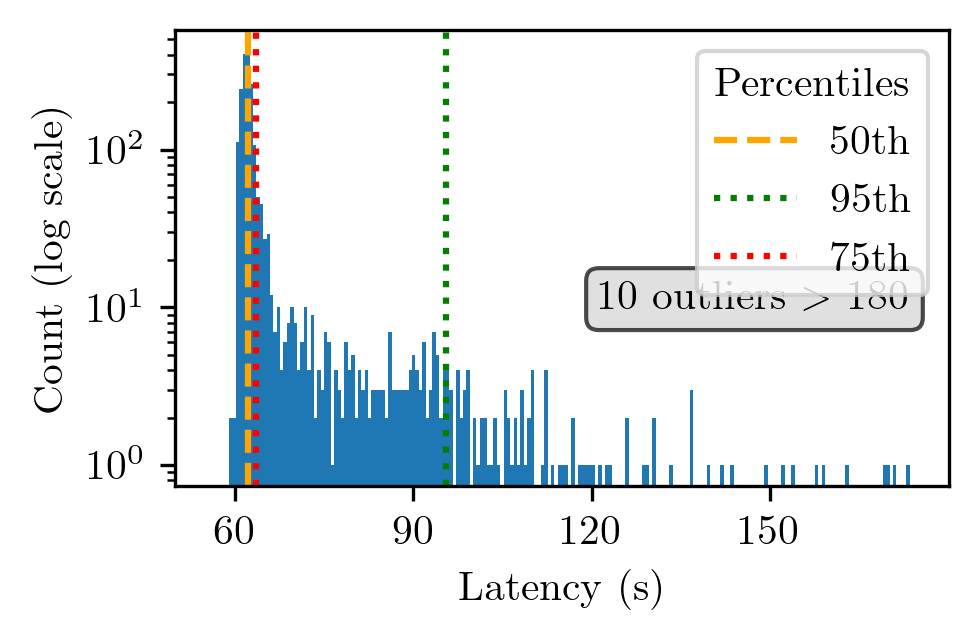

In [5]:
def analyze_ts_latency(peer_packets_df, result_df):
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'timestamp'])

    all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle), first row, handshake
    all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna()) | (all_data['command'] == '1001')
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 2
    valid_conn_ids = valid_conns[valid_conns].index

    all_ts_diffs = []
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        ts_mask = (commands == '1002') & (monero_flags == '1')
        ts_series = pd.Series(timestamps[ts_mask])

        # Get source IP for this connection
        source_ip = conn['source_ip'].iloc[0]

        if len(ts_series) > 2:
            differences = ts_series.diff().dt.total_seconds().dropna()
            all_ts_diffs.extend(differences)
            latency = differences.mean()

            # Append connection info for efficient processing
            conn_info.append({'source_ip': source_ip, 'latency': latency})
        else:
            # If no valid latency, still record the IP with None
            conn_info.append({'source_ip': source_ip, 'latency': None})

    conn_df = pd.DataFrame(conn_info)

    # Calculate average latency per IP (handles None values automatically)
    latency_by_ip = conn_df.groupby('source_ip')['latency'].mean()

    # Add to result_df
    result_df['ts_latency'] = result_df['source_ip'].map(latency_by_ip)

    quantiles = [0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
    set_plt_latex_format()
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['ts_latency'], bins=1000, log=True)
    plt.xlim(50, 180)
    plt.axvline(result_df['ts_latency'].quantile(0.5), color='orange', linestyle='--', label='50th')
    plt.axvline(result_df['ts_latency'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['ts_latency'].quantile(0.75), color='red', linestyle=':', label='75th')
    outlier_count = sum(x > 180 for x in result_df['ts_latency'])
    plt.text(0.95, 0.45, f'{outlier_count} outliers $>$ 180', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Latency (s)')
    plt.xticks([60,90,120,150])
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.savefig('results/graphs/ts_latency_dist.pdf')
    print(f"\nTimed Sync Latency Analysis:")
    print(f"Averaged over {len(result_df['ts_latency'])} individual connections: {np.mean(result_df['ts_latency'])}")
    print(f"Percentile distribution: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['ts_latency'].quantile(quantile)}")
    
    return result_df

result_df = analyze_ts_latency(peer_packets_df, result_df)


In [14]:
high_lat = result_df[result_df['ts_latency'] < 80]
print(high_lat)

           source_ip  packet_count  unique_commands unique_my_ports  \
0        1.145.8.140           158                5         [18080]   
4       1.175.74.101           686                4         [18080]   
6        1.55.44.152           391                5         [18080]   
7       100.0.25.108           391                5         [18080]   
11    100.19.102.155           309                4         [18080]   
...              ...           ...              ...             ...   
6209    99.252.41.14           898                4             [0]   
6210     99.30.63.33           223                4         [18080]   
6213    99.41.161.41           667                5         [18080]   
6214   99.50.224.179           438                4             [0]   
6221    99.90.80.108          3362                4             [0]   

             unique_peer_ids  has_support_flags  unique_source_ports  \
0      [1520070918116654848]               True                    1   
4  


Ping Analysis:
7435 connections.
Percentile distribution of number of Pings sent per connection: 
    0.5th percentile: 1.0
    0.75th percentile: 1.0
    0.9th percentile: 1.0
    0.95th percentile: 1.0
    0.99th percentile: 2.0
Percentile distribution of frequency of Pings if more than one is sent: 
    0.5th percentile: 0.0
    0.75th percentile: 0.0
    0.9th percentile: 0.0
    0.95th percentile: 0.0
    0.99th percentile: 54.92408706133331


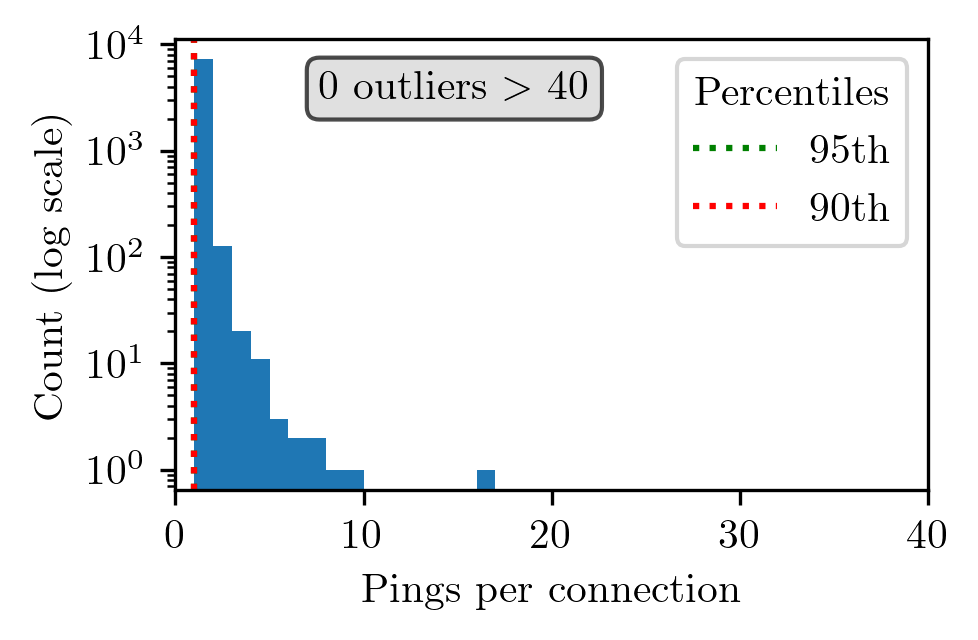

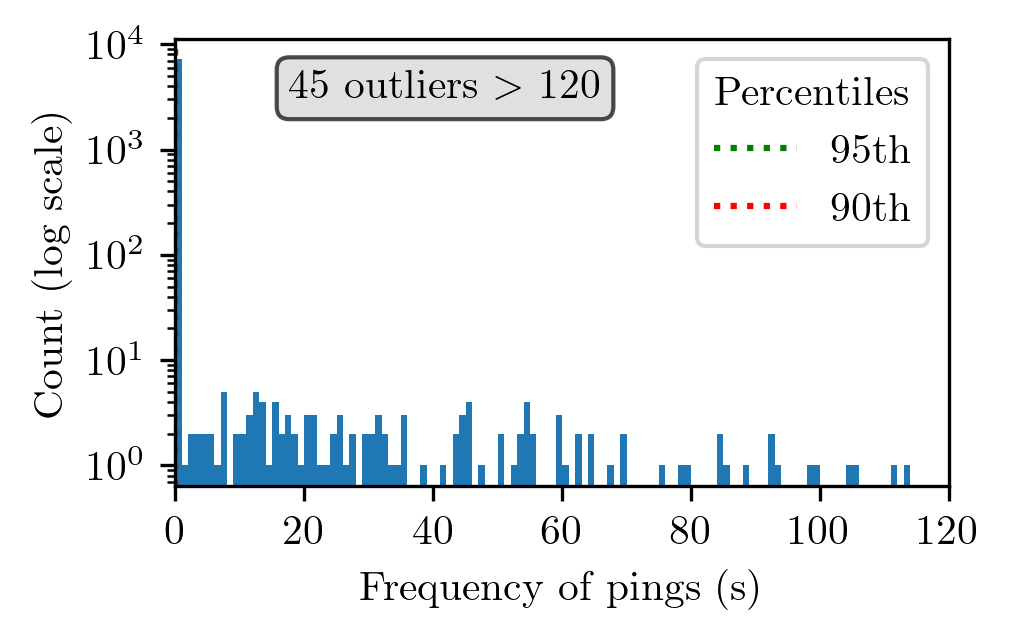


Handshake Analysis:
7435 connections.
Percentile distribution of number of Handshakes sent per connection: 
    0.5th percentile: 1.0
    0.75th percentile: 1.0
    0.9th percentile: 1.0
    0.95th percentile: 1.0
    0.99th percentile: 3.0
    0.999th percentile: 7.566000000000713
Percentile distribution of frequency of Handshakes if more than one is sent: 
    0.5th percentile: 0.0
    0.75th percentile: 0.0
    0.9th percentile: 0.0
    0.95th percentile: 0.0
    0.99th percentile: 561.3269456899988
    0.999th percentile: 4046.8962992841143


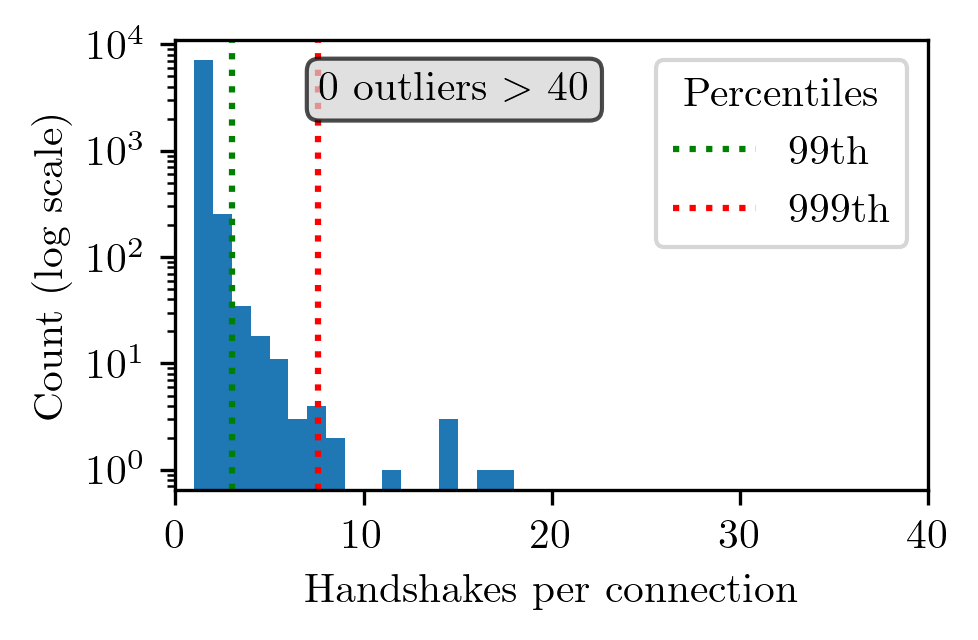

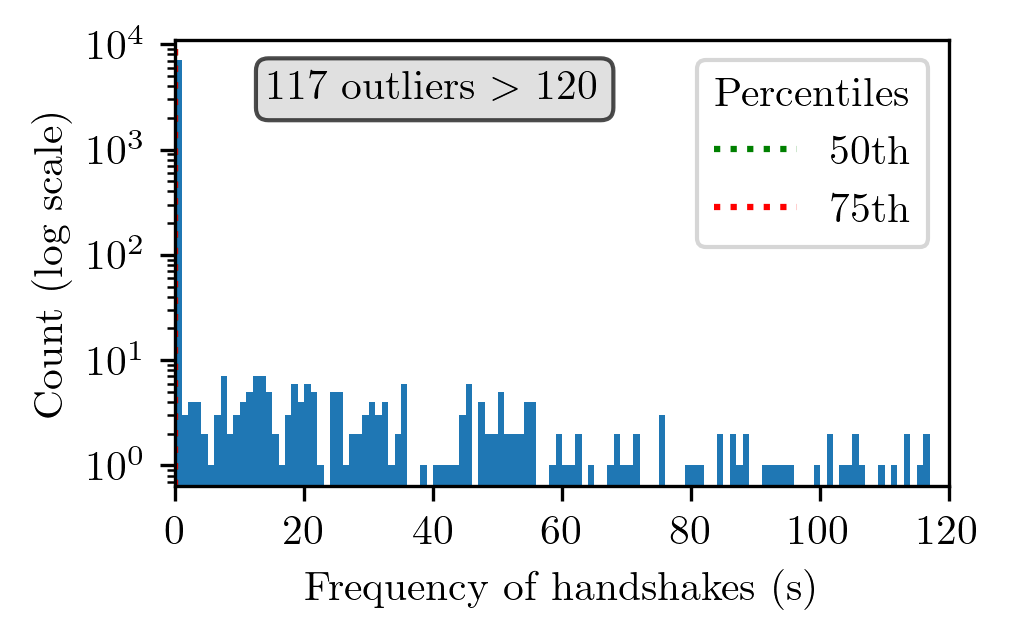

In [6]:
def analyze_connections(peer_packets_df, result_df):
    # for connection visualization stick to IP and dont split the connection for repeated Handshakes (known pattern)
    all_data = peer_packets_df.copy()
    all_data = all_data.sort_values(['source_ip', 'timestamp'])

    all_data['source_ip_cat'] = all_data['source_ip'].astype('category')

    # shift to later compare current vs prev IP
    all_data['prev_ip'] = all_data['source_ip_cat'].shift(1) 
    all_data['time_diff'] = all_data['timestamp'].diff().dt.total_seconds()

    # mask logic to identify breaks if IP changes, time is bigger 120s (idle connection), or first row
    all_data['is_break'] = (all_data['source_ip_cat'] != all_data['prev_ip']) | (all_data['time_diff'] > 120) | (all_data['time_diff'].isna())
    all_data['connection_id'] = all_data['is_break'].cumsum()

    # filter already for valid conns
    grouped = all_data.groupby('connection_id')
    connection_sizes = grouped.size()
    valid_conns = connection_sizes >= 1
    valid_conn_ids = valid_conns[valid_conns].index
    
    conn_info = []

    for conn_id in valid_conn_ids:
        conn = grouped.get_group(conn_id)
        commands = np.array(conn['command'])
        monero_flags = np.array(conn['monero_flags'])
        timestamps = np.array(conn['timestamp'])
        source_ip = conn['source_ip'].iloc[0]

        conn_row = {
            'source_ip': source_ip,
            'total_pings': 1,
            'ping_frequency': 0,
            'total_handshakes': 1,
            'handshake_frequency': 0
        }

        # Ping Analysis
        ping_mask = (commands == '1003')
        ping_timestamps = timestamps[ping_mask]
        if len(ping_timestamps) > 1:
            ping_series = pd.Series(ping_timestamps)
            ping_differences = ping_series.diff().dt.total_seconds().dropna()

            conn_row['total_pings'] = len(ping_timestamps)
            conn_row['ping_frequency'] = ping_differences.mean()
        
        # Handshake Analysis
        handshake_mask = (commands == '1001')
        handshake_timestamps = timestamps[handshake_mask]
        if len(handshake_timestamps) > 1:
            handshake_series = pd.Series(handshake_timestamps)
            handshake_diffs = handshake_series.diff().dt.total_seconds().dropna()

            conn_row['total_handshakes'] = len(handshake_timestamps)
            conn_row['handshake_frequency'] = handshake_diffs.mean()
        
        conn_info.append(conn_row)
    
    conn_df = pd.DataFrame(conn_info)

    ping_frequency_by_ip = conn_df.groupby('source_ip')['ping_frequency'].mean()
    result_df['ping_frequency'] = result_df['source_ip'].map(ping_frequency_by_ip)
    pings_by_ip = conn_df.groupby('source_ip')['total_pings'].max()
    result_df['total_pings'] = result_df['source_ip'].map(pings_by_ip)

    handshake_frequency_by_ip = conn_df.groupby('source_ip')['handshake_frequency'].mean()
    handshakes_by_ip = conn_df.groupby('source_ip')['total_handshakes'].max()
    result_df['handshake_frequency'] = result_df['source_ip'].map(handshake_frequency_by_ip)
    result_df['total_handshakes'] = result_df['source_ip'].map(handshakes_by_ip)
    
    # Ping Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99]
    print(f"\nPing Analysis:")
    print(f"{len(result_df['total_pings'])} connections.")
    print(f"Percentile distribution of number of Pings sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['total_pings'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Pings if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['ping_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['total_pings'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    plt.axvline(result_df['total_pings'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['total_pings'].quantile(0.9), color='red', linestyle=':', label='90th')

    outlier_count = sum(x > 40 for x in result_df['total_pings'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 40', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Pings per connection')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['ping_frequency'], bins=120, range=(0, 120), log=True)
    plt.xlim(0, 120)
    plt.axvline(result_df['ping_frequency'].quantile(0.95), color='green', linestyle=':', label='95th')
    plt.axvline(result_df['ping_frequency'].quantile(0.9), color='red', linestyle=':', label='90th')
    
    outlier_count = sum(x > 120 for x in result_df['ping_frequency'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Frequency of pings (s)')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    # Handshake Plots
    quantiles = [0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
    print(f"\nHandshake Analysis:")
    print(f"{len(result_df['total_handshakes'])} connections.")
    print(f"Percentile distribution of number of Handshakes sent per connection: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['total_handshakes'].quantile(quantile)}")
    print(f"Percentile distribution of frequency of Handshakes if more than one is sent: ")
    for quantile in quantiles:
        print(f"    {quantile}th percentile: {result_df['handshake_frequency'].quantile(quantile)}")
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['total_handshakes'], bins=40, range=(0, 40), log=True)
    plt.xlim(0, 40)
    plt.axvline(result_df['total_handshakes'].quantile(0.99), color='green', linestyle=':', label='99th')
    plt.axvline(result_df['total_handshakes'].quantile(0.999), color='red', linestyle=':', label='999th')

    outlier_count = sum(x > 40 for x in result_df['total_handshakes'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 40', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Handshakes per connection')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()
    
    plt.figure(figsize=(3.13, 2), dpi=300)
    plt.hist(result_df['handshake_frequency'], bins=120, range=(0, 120), log=True)
    plt.xlim(0, 120)
    plt.axvline(result_df['handshake_frequency'].quantile(0.50), color='green', linestyle=':', label='50th')
    plt.axvline(result_df['handshake_frequency'].quantile(0.75), color='red', linestyle=':', label='75th')
    
    outlier_count = sum(x > 120 for x in result_df['handshake_frequency'])
    plt.text(0.55, 0.93, f'{outlier_count} outliers $>$ 120', fontsize=10,
             transform=plt.gca().transAxes, ha='right', va='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))
    plt.xlabel(f'Frequency of handshakes (s)')
    plt.ylabel(f'Count (log scale)')
    plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
    plt.tight_layout(pad=0.2)
    plt.show()

    return result_df
    
result_df = analyze_connections(peer_packets_df, result_df)



# Peer Lists per Peer
- all peer lists of a peer aggregated

In [7]:
unique_peers_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.unique().tolist()).reset_index()
unique_peers_by_source.columns = ['source_ip', 'unique_peer_ips']
#print(unique_peers_by_source.head())

unique_peers_by_source['peer_count'] = unique_peers_by_source['unique_peer_ips'].apply(len)
unique_peers_by_source = unique_peers_by_source[unique_peers_by_source['peer_count'] > 250]

# Analyze sizes
peer_counts = unique_peers_by_source.set_index('source_ip')['peer_count']
print("Peer list size statistics:")
print(peer_counts.describe())
print(f"\nTop 5 sources by peer count:")
print(peer_counts.nlargest(5))

# Analyze overlap between sources
from itertools import combinations

# Convert to dict for easier access
peer_sets = {row['source_ip']: set(row['unique_peer_ips']) 
            for _, row in unique_peers_by_source.iterrows()}

# Calculate pairwise overlaps
overlaps = []
for source1, source2 in combinations(peer_sets.keys(), 2):
   intersection = len(peer_sets[source1] & peer_sets[source2])
   union = len(peer_sets[source1] | peer_sets[source2])
   jaccard = intersection / union if union > 0 else 0
   
   overlaps.append({
       'source1': source1, 'source2': source2,
       'intersection': intersection, 'jaccard_similarity': jaccard,
       'union': union
   })

overlap_df = pd.DataFrame(overlaps)

max_sim_by_ip = overlap_df.groupby('source1')['jaccard_similarity'].max()
result_df['max_pl_sim'] = result_df['source_ip'].map(max_sim_by_ip)

print(f"\nHighest overlaps:")
print(overlap_df.nlargest(5, 'intersection')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])
#print(f"\nSmallest overlaps:")
#print(overlap_df.nsmallest(5, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
print(f"\nHighest overlaps:")
print(overlap_df.nlargest(15, 'intersection')[['source1', 'source2', 'intersection', 'jaccard_similarity']])

Peer list size statistics:
count    3000.000000
mean      917.924000
std       503.980151
min       251.000000
25%       689.000000
50%       840.000000
75%      1004.000000
max      4620.000000
Name: peer_count, dtype: float64

Top 5 sources by peer count:
source_ip
185.143.228.198    4620
146.70.119.59      4359
170.64.251.201     4271
5.78.87.100        4263
178.156.169.60     4250
Name: peer_count, dtype: int64

Highest overlaps:
                source1         source2  intersection  union  \
2054231  178.156.169.60     5.78.87.100          3409   5104   
1472816  157.245.30.212     5.78.87.100          3397   5055   
1471718  157.245.30.212  178.156.169.60          3391   5048   
3482786    34.81.215.36     5.78.87.100          3384   5036   
1725551  170.64.251.201     5.78.87.100          3376   5158   

         jaccard_similarity  
2054231            0.667908  
1472816            0.672008  
1471718            0.671751  
3482786            0.671962  
1725551            0.654517

In [8]:
SIMILARITY_THRESHOLD = result_df['max_pl_sim'].quantile(0.95)
high_sim_pairs = overlap_df[overlap_df['jaccard_similarity'] >= SIMILARITY_THRESHOLD].copy()
#print(high_sim_pairs.head())

groups = []

for _, row in high_sim_pairs.iterrows():
    source1, source2 = row['source1'], row['source2']
    sim = row['jaccard_similarity']

    found_group = None
    for group in groups:
        if source1 in group['sources'] or source2 in group['sources']:
            found_group = group
            break
    
    if not found_group is None:
        found_group['sources'].add(source1)
        found_group['sources'].add(source2)
        found_group['similarities'].append(sim)
    else:
        groups.append({
            'sources': {source1, source2},
            'similarities': [sim]
        })
    
final_groups = []

for group in groups:
    if len(group['sources']) > 1:
        sources_list = list(group['sources'])
        similarities = group['similarities']
        final_groups.append({
            'sources': sources_list,
            'avg_similarity': sum(similarities) / len(similarities),
            'min_similarity': min(similarities),
            'max_similarity': max(similarities),
            'num_pairs': len(similarities)
        })

print(f"\nFound {len(final_groups)} similarity groups.\nMost similar groups: ")
source_to_group = {}
for i, group in enumerate(final_groups, 1):
    for source_ip in group['sources']:
        source_to_group[source_ip] = len(group['sources'])
    if len(group['sources']) > 2: #group['avg_similarity'] > 0.65:
        print(f"Group {i} ({len(group['sources'])} sources):")
        print(f"  Sources: {group['sources']}")
        print(f"  Avg similarity: {group['avg_similarity']:.3f}")
        print(f"  Range: {group['min_similarity']:.3f} - {group['max_similarity']:.3f}")
        print(f"  Based on {group['num_pairs']} pairs")

result_df[f'sim_group_{node}'] = result_df['source_ip'].map(source_to_group)

if final_groups:
    group_sizes = [len(group['sources']) for group in final_groups]
    avg_similarities = [group['avg_similarity'] for group in final_groups]
    print(f"\nOverall stats:")
    print(f"Total sources in groups: {sum(group_sizes)}")
    print(f"Average group size: {sum(group_sizes)/len(group_sizes):.1f}")
    print(f"Largest group: {max(group_sizes)} sources")
    print(f"Average of group similarities: {sum(avg_similarities)/len(avg_similarities):.3f}")


Found 36 similarity groups.
Most similar groups: 
Group 1 (3 sources):
  Sources: ['102.129.234.101', '102.129.234.197', '156.146.39.201']
  Avg similarity: 0.567
  Range: 0.407 - 0.877
  Based on 3 pairs
Group 2 (3 sources):
  Sources: ['173.239.216.9', '37.140.254.81', '103.163.220.93']
  Avg similarity: 0.879
  Range: 0.859 - 0.890
  Based on 3 pairs
Group 4 (118 sources):
  Sources: ['159.203.55.112', '185.41.40.39', '108.221.164.219', '34.139.39.59', '34.133.52.226', '178.128.128.142', '188.91.6.75', '65.109.237.177', '37.27.251.140', '157.245.29.221', '34.159.89.210', '79.117.213.112', '104.155.200.188', '188.245.230.55', '95.252.202.118', '138.199.238.32', '35.203.40.255', '216.219.85.122', '167.99.19.151', '54.39.48.96', '170.64.251.238', '176.9.0.187', '74.14.205.208', '185.218.124.120', '37.27.219.15', '170.64.251.201', '134.199.169.4', '34.95.247.125', '188.166.139.142', '109.70.115.118', '139.144.16.114', '62.178.36.232', '188.40.127.121', '5.161.47.56', '185.148.3.171', '

# Peer Lists Individually

In [22]:
pl_by_source = peers_df.groupby('pl_identifier').agg({
    'ip': lambda x: x.tolist(),
    'source_ip': 'first',
    }).reset_index()
pl_by_source.columns = ['source_pl', 'peer_ips', 'source_ip']
#print(unique_peers_by_source.head())

pl_by_source['peer_count'] = pl_by_source['peer_ips'].apply(len)
pl_by_source = pl_by_source[pl_by_source['peer_count'] > 249]

# Analyze sizes
peer_counts = pl_by_source.set_index('source_pl')['peer_count']

pl_counters = {row['source_pl']: Counter(row['peer_ips'])
               for _, row in pl_by_source.iterrows()}

source_ip_lookup = pl_by_source.set_index('source_pl')['source_ip'].to_dict()

overlaps = []
for source1, source2 in combinations(pl_counters.keys(), 2):
    counter1, counter2 = pl_counters[source1], pl_counters[source2]
    
    # Common IPs (intersection)
    common_ips = counter1 & counter2
    intersection_count = sum(common_ips.values())
    
    # Union with frequencies
    union_counter = counter1 | counter2
    union_count = sum(union_counter.values())
    
    jaccard = intersection_count / union_count if union_count > 0 else 0
   
    overlaps.append({
        'source1': source1, 
        'source2': source2,
        'source1_ip': source_ip_lookup[source1],
        'source2_ip': source_ip_lookup[source2],
        'intersection': intersection_count, 
        'jaccard_similarity': jaccard,
        'union': union_count
    })

overlap_df = pd.DataFrame(overlaps)
overlap_df.to_csv(f'results/node_results/{node}_pl_df.csv', index=False)

0.5th percentile: 0.030927835051546393
0.7th percentile: 0.035196687370600416
0.8th percentile: 0.03734439834024896
0.9th percentile: 0.041666666666666664
0.95th percentile: 0.04602510460251046
0.99th percentile: 0.05485232067510549
0.999th percentile: 0.13636363636363635
0.9999th percentile: 0.17096018735362997

Highest overlaps:
                                            source1  \
1552861  2025-06-03 17:46:28.608671_185.213.154.250   
1552900  2025-06-03 17:46:28.608671_185.213.154.250   
1558108  2025-06-03 17:47:29.564164_185.213.154.250   
2119542      2025-06-03 21:01:08.476674_46.3.240.86   
1819802   2025-06-03 19:05:42.466434_193.32.127.216   
1939821    2025-06-03 19:50:57.290822_186.96.212.37   
1939818    2025-06-03 19:50:57.290822_186.96.212.37   
1968112    2025-06-03 20:03:07.994138_186.96.212.37   
1930809    2025-06-03 19:49:51.889004_186.96.212.37   
1940055    2025-06-03 19:50:57.290822_186.96.212.37   
1930790    2025-06-03 19:49:51.889004_186.96.212.37   
1930812

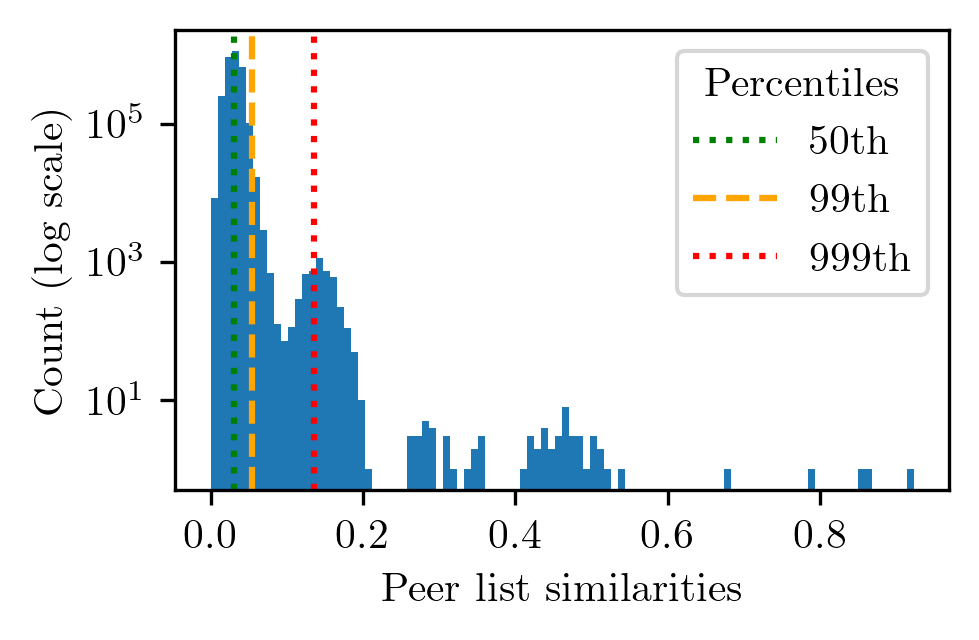

In [23]:
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999, 0.9999]
for quantile in quantiles:
    print(f"{quantile}th percentile: {overlap_df['jaccard_similarity'].quantile(quantile)}")
print(f"\nHighest overlaps:")
print(overlap_df.nlargest(15, 'jaccard_similarity')[['source1', 'source2', 'intersection', 'union', 'jaccard_similarity']])

plt.figure(figsize=(3.13, 2), dpi=300)
plt.hist(overlap_df['jaccard_similarity'], bins=100, log=True)
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.99), color='orange', linestyle='--', label='99th')
plt.axvline(overlap_df['jaccard_similarity'].quantile(0.999), color='red', linestyle=':', label='999th')
plt.xlabel(f'Peer list similarities')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()

In [ ]:
# DIVERSITY
def calc_diversity(ip_list):
    subnets = set()
    valid_count = 0
    
    for ip in ip_list:
        try:
            subnet = str(ipaddress.IPv4Network(f"{ip}/24", strict=False).network_address) + "/24"
            subnets.add(subnet)
            valid_count += 1
        except:
            continue
    
    return len(subnets) / valid_count if valid_count > 0 else 0

pl_by_source['pl_diversity'] = pl_by_source['peer_ips'].apply(calc_diversity)

mean_pl_div = pl_by_source.groupby('source_ip')['pl_diversity'].mean()
result_df['avg_pl_diversity'] = result_df['source_ip'].map(mean_pl_div)



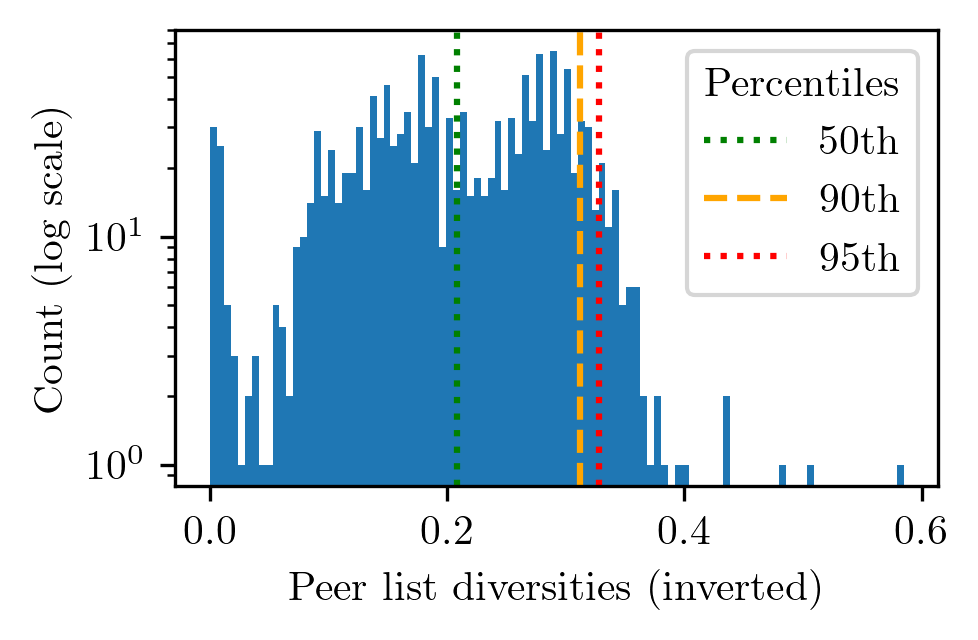

In [38]:
plt.figure(figsize=(3.13, 2), dpi=300)
inverted_data = 1 - result_df['avg_pl_diversity']
plt.hist(inverted_data, bins=100, log=True)
plt.axvline(inverted_data.quantile(0.50), color='green', linestyle=':', label='50th')
plt.axvline(inverted_data.quantile(0.90), color='orange', linestyle='--', label='90th')
plt.axvline(inverted_data.quantile(0.95), color='red', linestyle=':', label='95th')
plt.xlabel(f'Peer list diversities (inverted)')
plt.ylabel(f'Count (log scale)')
plt.legend(title='Percentiles', fontsize=10, title_fontsize=10)
plt.tight_layout(pad=0.2)
plt.show()
#plt.savefig("results/graphs/pl_sims.pdf")

In [28]:
for _, row in pl_by_source.iterrows():
    if row['pl_diversity'] < 0.5:
        print(row)
        break

source_pl                2025-06-03 10:37:25.979698_146.70.119.59
peer_ips        [162.218.65.2, 91.198.115.62, 162.218.65.204, ...
source_ip                                           146.70.119.59
peer_count                                                    250
pl_diversity                                                0.384
Name: 21, dtype: object


SOURCE IP ANALYSIS:

Max avg_ip_frequency: 18.71
Quantiles for avg_ip_frequency: 
   0.5: 1.02
   0.7: 1.03
   0.8: 1.114000000000001
   0.9: 1.39
   0.95: 1.8434999999999993
   0.99: 3.6393999999999957

Max max_ip_frequency: 142
Quantiles for max_ip_frequency: 
   0.5: 3.0
   0.7: 3.0
   0.8: 4.0
   0.9: 6.0
   0.95: 8.0
   0.99: 16.0


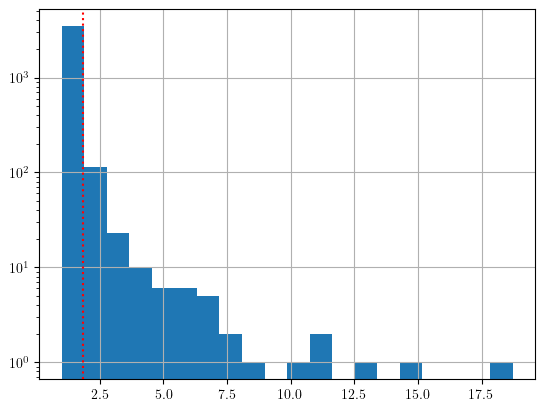

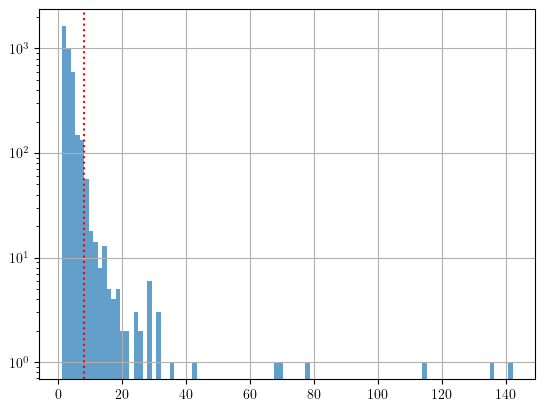

TARGET IP ANALYSIS:

Max avg_frequency_per_source: 12.0
Quantiles for avg_frequency_per_source: 
   0.5: 1.21
   0.7: 1.27
   0.8: 1.35
   0.9: 1.62
   0.95: 2.0
   0.99: 3.5

Max max_frequency_in_source: 142
Quantiles for max_frequency_in_source: 
   0.5: 3.0
   0.7: 8.0
   0.8: 14.0
   0.9: 19.0
   0.95: 22.0
   0.99: 27.0


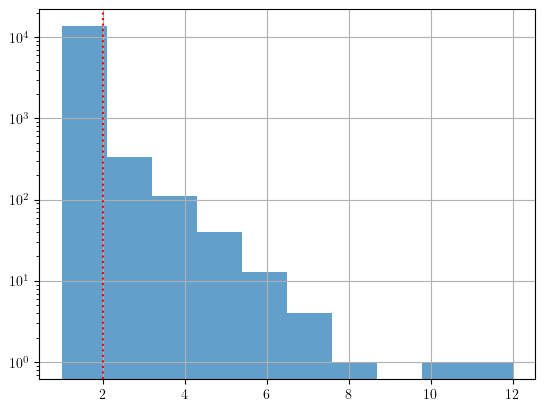

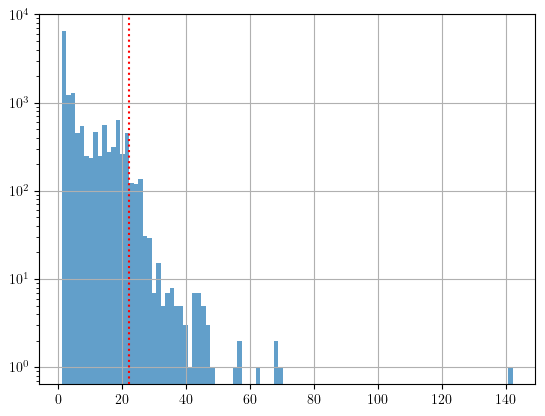

DISTRIBUTION STATISTICS:
total_unique_target_ips: 14169.00
total_unique_source_ips: 3654.00
avg_connections_per_source: 1000.31
avg_unique_ips_per_source: 791.06


In [10]:
all_ips_by_source = peers_df.groupby('source_ip')['ip'].apply(lambda x: x.tolist()).reset_index()
#print(all_ips_by_source.head(5))
rows = [] 
for _, row in all_ips_by_source.iterrows():
    source_ip = row['source_ip']
    ip_list = row['ip']
    
    # Count occurrences of each IP for this source
    ip_counts = Counter(ip_list)
    
    # Create rows for each unique IP
    for ip, count in ip_counts.items():
        rows.append({
            'source_ip': source_ip,
            'target_ip': ip,
            'count': count,
            'total_ips_in_source': len(ip_list),
            'unique_ips_in_source': len(ip_counts)
        })

ip_analysis_df = pd.DataFrame(rows)

source_summary = ip_analysis_df.groupby('source_ip').agg({
    'target_ip': 'nunique',  # unique IPs per source
    'count': ['sum', 'mean', 'max', 'std'],  # count statistics
    'total_ips_in_source': 'first'
}).round(2)

source_summary.columns = ['unique_target_ips', 'total_connections', 
                         'avg_ip_frequency', 'max_ip_frequency', 
                         'std_ip_frequency', 'total_ips_in_list']

print("SOURCE IP ANALYSIS:")
columns = ['avg_ip_frequency', 'max_ip_frequency']
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
for c in columns: 
    print(f"\nMax {c}: {source_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {source_summary[c].quantile(q)}"))
#print(source_summary.head())

source_summary['avg_ip_frequency'].hist(bins=20, log=True)
plt.axvline(source_summary["avg_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

source_summary['max_ip_frequency'].hist(bins=100, alpha=0.7, log=True)
plt.axvline(source_summary["max_ip_frequency"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary = ip_analysis_df.groupby('target_ip').agg({
    'source_ip': 'nunique',  # in how many sources this IP appears
    'count': ['sum', 'mean', 'max'],  # frequency statistics
}).round(2)

target_summary.columns = ['appears_in_n_sources', 'total_occurrences', 
                         'avg_frequency_per_source', 'max_frequency_in_source']

print("TARGET IP ANALYSIS:")

columns = ["avg_frequency_per_source", "max_frequency_in_source"]
for c in columns: 
    print(f"\nMax {c}: {target_summary[c].max()}")
    print(f"Quantiles for {c}: ")
    for q in quantiles:
        print((f"   {q}: {target_summary[c].quantile(q)}"))
#print(target_summary.sort_values('total_occurrences', ascending=False).head())
target_summary["avg_frequency_per_source"].hist(bins=10, alpha=0.7, log=True)
plt.axvline(target_summary["avg_frequency_per_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

target_summary["max_frequency_in_source"].hist(bins=100, alpha=0.7, log=True)
plt.axvline(target_summary["max_frequency_in_source"].quantile(0.95), color='red', linestyle=':', label='95th')
plt.show()

distribution_stats = {
    'total_unique_target_ips': ip_analysis_df['target_ip'].nunique(),
    'total_unique_source_ips': ip_analysis_df['source_ip'].nunique(),
    'avg_connections_per_source': ip_analysis_df.groupby('source_ip')['count'].sum().mean(),
    'avg_unique_ips_per_source': ip_analysis_df.groupby('source_ip')['target_ip'].nunique().mean(),
}

print("DISTRIBUTION STATISTICS:")
for key, value in distribution_stats.items():
    print(f"{key}: {value:.2f}")



In [11]:
result_df.to_csv(f'results/node_results/{node}_result_df.csv', index=False)

In [12]:
df = pd.read_csv(f'results/node_results/{node}_result_df.csv')
print(df.head())

       source_ip  packet_count  unique_commands unique_my_ports  \
0    1.145.138.8             1                1         [18080]   
1   1.158.20.139             2                2         [18080]   
2  1.160.138.108            21                4         [18080]   
3  1.161.142.222           260                4         [18080]   
4    1.2.239.209             1                1         [18080]   

          unique_peer_ids  has_support_flags  unique_source_ports  ts_latency  \
0  [16051594327072124928]               True                    1         NaN   
1   [1769162559250729984]               True                    2         NaN   
2   [9420499685128224768]               True                    2         NaN   
3   [3186886954086273536]               True                    1   62.645544   
4   [7698744061385046016]               True                    1         NaN   

   ping_frequency  total_pings  handshake_frequency  total_handshakes  \
0             0.0            1       